  # GLOBAL SETTINGS

In [82]:
# python peripherals
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

# numpy
import numpy

# ipython
from IPython.display import display, HTML

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# pytorch
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

# deep signature
from deep_signature.data_generation.curve_generation import LevelCurvesGenerator
from deep_signature.data_manipulation import curve_processing

# utils
from utils import common as common_utils
from utils import evaluation as evaluation_utils
from utils import plot as plot_utils
from utils import settings

  # LEARNING CURVES

0.5803676247596741
0.6381140947341919


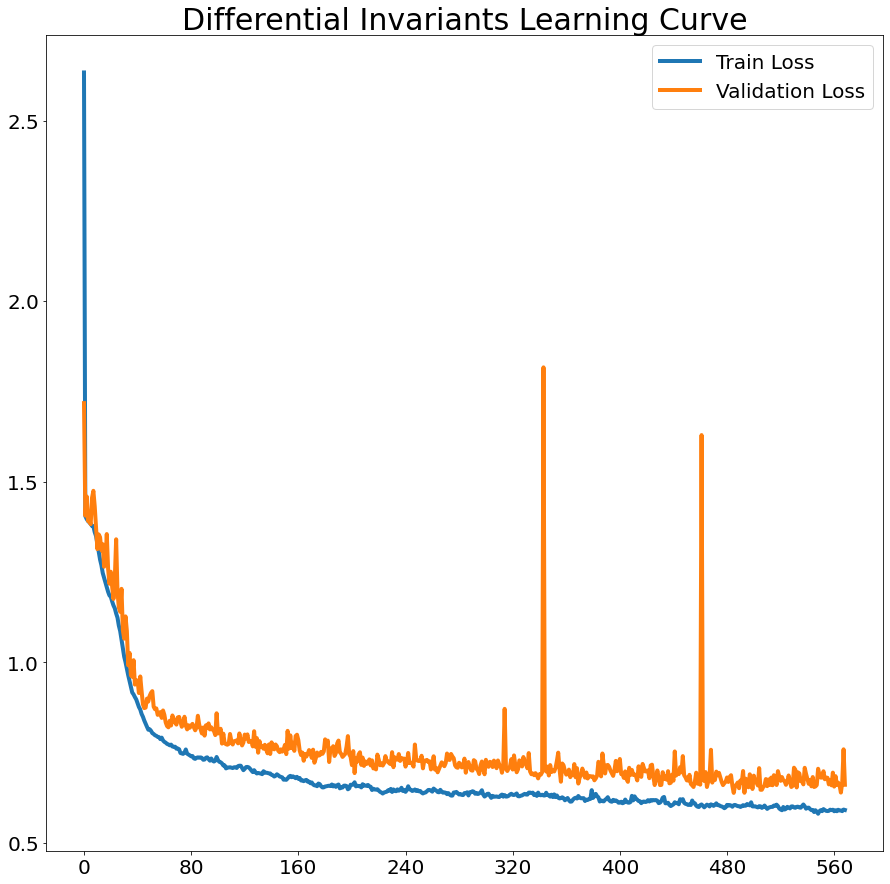

In [83]:
def plot_learning_curve(results_dir_path, title):
    latest_subdir = common_utils.get_latest_subdirectory(results_dir_path)
    results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()
    # results = numpy.load(f"C:/deep-signature-data/results/arclength/similarity/2022-02-05-10-46-15/results.npy", allow_pickle=True).item()

    start_index = 0
    end_index = None
    train_loss_array = results['train_loss_array'][start_index:] if end_index is None else results['train_loss_array'][start_index:end_index]
    validation_loss_array = results['validation_loss_array'][start_index:] if end_index is None else results['validation_loss_array'][start_index:end_index]

    train_loss_array_no_nan = train_loss_array[~numpy.isnan(train_loss_array)]
    validation_loss_array_no_nan = validation_loss_array[~numpy.isnan(validation_loss_array)]

    epochs_list = numpy.array(range(len(train_loss_array)))

    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)

    ax.plot(epochs_list, train_loss_array, label='Train Loss', linewidth=4.0)
    ax.plot(epochs_list, validation_loss_array, label='Validation Loss', linewidth=4.0)
    ax.set_title(title, fontsize=30)

    plt.legend(fontsize=20, title_fontsize=20)

    print(numpy.min(train_loss_array_no_nan))
    print(numpy.min(validation_loss_array_no_nan))

    plt.show()
    
group = 'euclidean'
# data_dir = settings.data_dir
curvature_results_dir_path = common_utils.get_results_dir(data_dir=settings.data_dir, invariant='curvature', group=group)
arclength_results_dir_path = common_utils.get_results_dir(data_dir=settings.data_dir, invariant='arclength', group=group)
all_results_dir_path = common_utils.get_results_dir(data_dir=settings.data_dir, invariant='diff_inv', group=group)

# level_curves_curvature_tuplets_results_dir_path, level_curves_arclength_tuplets_results_dir_path = common_utils.get_results_dir_path(transform_type=transform_type)
# plot_learning_curve(level_curves_curvature_tuplets_results_dir_path, 'Curvature Learnin"g Curve')
# plot_learning_curve(results_dir_path=arclength_results_dir_path, title='Arc-Length Learning Curve')
plot_learning_curve(results_dir_path=all_results_dir_path, title='Differential Invariants Learning Curve')
# plot_learning_curve(results_dir_path=curvature_results_dir_path, title='Curvature Learning Curve')

# PLOT CURVES

In [84]:
# def plot_sample(ax, sample, color, zorder, point_size=10, alpha=1, x=None, y=None):
#     if sample is not None:
#         x = sample[:, 0]
#         y = sample[:, 1]

#     return ax.scatter(
#         x=x,
#         y=y,
#         s=point_size,
#         color=color,
#         alpha=alpha,
#         zorder=zorder)


# # curves_full = LevelCurvesGenerator.load_curves(dir_path=os.path.normpath("C:/GitHub/deep-signature/applets/level_curves/evaluation/"))
# curves_full = LevelCurvesGenerator.load_curves(dir_path=os.path.normpath(settings.level_curves_dir_path_test))
# curves = []
# for curve in curves_full:
#     if 1000 < curve.shape[0] < 1400:
#         curves.append(curve)

# for curve in curves[:6]:
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(40, 20))
#     plot_sample(ax=ax, sample=curve, color='red', zorder=10)
#     plt.show()        

  # CURVE RECORDS EXTRACTION

In [85]:
import warnings
warnings.filterwarnings("ignore")

# constants
true_arclength_colors = ['#FF8C00', '#444444']
predicted_arclength_colors = ['#AA0000', '#0000AA']
sample_colors = ['#FF0000', '#0000FF']
curve_colors = ['#FF0000', '#0000FF', '#FF9D11']
limit = 2
factor_extraction_limit = -1
comparison_curves_count = 2
sampling_ratio = 1
anchors_ratio = None

# randomness
numpy.random.seed(30)

# models
models = common_utils.load_models(data_dir=settings.data_dir, group=group, distributed=True)

# curves
# curves_full = numpy.load(file=os.path.normpath("C:/deep-signature-data/level-curves/curves/test_raw/multimodality_35/profiles_0_7.npy"), allow_pickle=True)
curves_full = LevelCurvesGenerator.load_curves(dir_path=common_utils.get_test_curves_dir(data_dir=settings.data_dir))
# curves_full = LevelCurvesGenerator.load_curves(dir_path=os.path.normpath("C:/GitHub/deep-signature/applets/level_curves/evaluation/"))

curves = []
for curve in curves_full:
    if 1000 < curve.shape[0] < 1400:
        # curve = curve_processing.smooth_curve(
        #     curve=curve,
        #     iterations=1,
        #     window_length=33,
        #     poly_order=2)
        curves.append(curve)

# curves = curves_full

print(len(curves))

numpy.random.shuffle(curves)
curves_limited = curves[:limit]
factor_extraction_curves = curves[factor_extraction_limit:]

# create color map
color_map = plt.get_cmap('rainbow', limit)

# generate curve records
curve_records = evaluation_utils.generate_curve_records(
    models=models,
    curves=curves_limited,
    factor_extraction_curves=factor_extraction_curves,
    transform_type=group,
    comparison_curves_count=comparison_curves_count,
    sampling_ratio=sampling_ratio,
    anchors_ratio=anchors_ratio,
    neighborhood_supporting_points_count=settings.default_supporting_points_count,
    section_supporting_points_count=settings.default_supporting_points_count)

DifferentialInvariantsNet(
  (_regressor): Sequential(
    (0): Linear(in_features=14, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sine()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sine()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sine()
    (9): Linear(in_features=8, out_features=8, bias=True)
    (10): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sine()
    (12): Linear(in_features=8, out_features=4, bias=True)
    (13): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Sine()
    (15): Linear(in_features=4, out_features=4, bias=True)
    (16): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, t

  # EVALUATE SIGNATURES

In [86]:
plot_utils.plot_curve_comparisons(
    curve_records=curve_records, 
    curve_colors=curve_colors,
    sampling_ratio=sampling_ratio,
    transformation_group_type=group,
    plot_to_screen=True,
    normalize_signature=False)